In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('donacion_sangre.csv')
df.head()

,Recency,Frequency,Monetary,Time,Donated
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [5]:
df['Donated'].value_counts()

0    570
1    178
Name: Donated, dtype: int64

In [7]:
df= df.drop_duplicates()

In [8]:
print('% de etiquetas 1: {:.2%}'.format(len(df[df['Donated']==1])/len(df)))
print('% de etiquetas 0: {:.2%}'.format(len(df[df['Donated']==0])/len(df)))

% de etiquetas 1: 27.95%
% de etiquetas 0: 72.05%


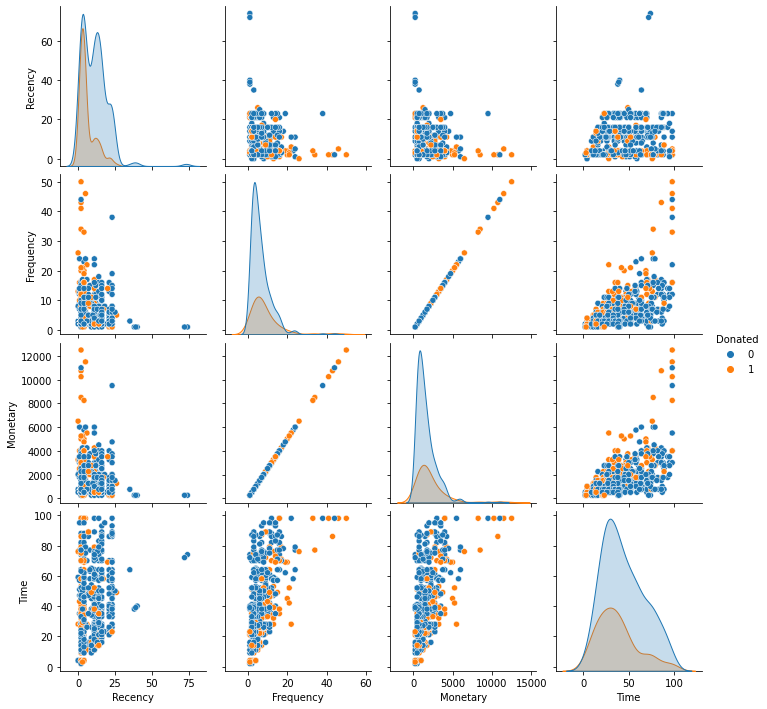

In [9]:
sns.pairplot(df, hue='Donated')

In [10]:
(df['Monetary']/df['Frequency']).unique()

array([250.])

In [11]:
df=df.drop('Monetary', axis=1)

In [13]:
df['Freq_month']=df['Frequency']/df['Time']

In [14]:
df.head()

,Recency,Frequency,Time,Donated,Freq_month
0,2,50,98,1,0.510204
1,0,13,28,1,0.464286
2,1,16,35,1,0.457143
3,2,20,45,1,0.444444
4,1,24,77,0,0.311688


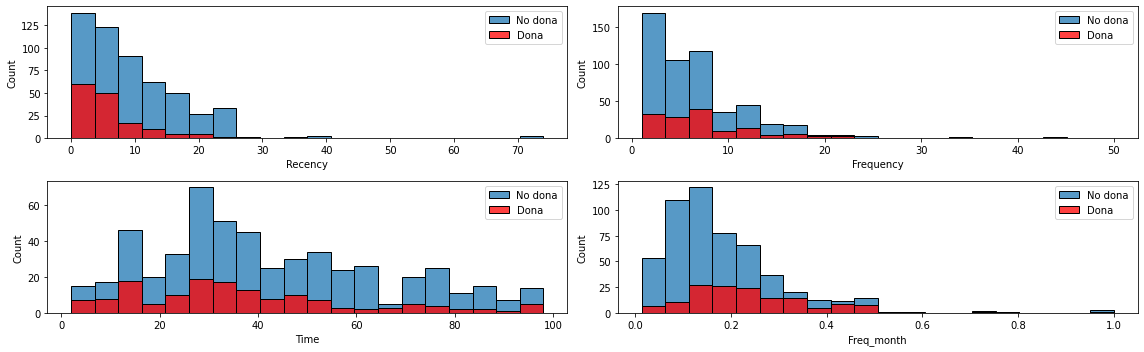

In [15]:
fig, axes= plt.subplots(2,2, figsize=(16,5))
axes=axes.flatten()

for i, col in enumerate (df.drop('Donated', axis=1)):
    sns.histplot(df.loc[:,col], ax=axes[i], bins=20, binrange=[min(df[col]),max(df[col])], label='No dona')
    sns.histplot(df.loc[df['Donated']==1,col], ax=axes[i], color='red', bins=20, 
                 binrange=[min(df[col]),max(df[col])], label='Dona')
    axes[i].legend()
plt.tight_layout()

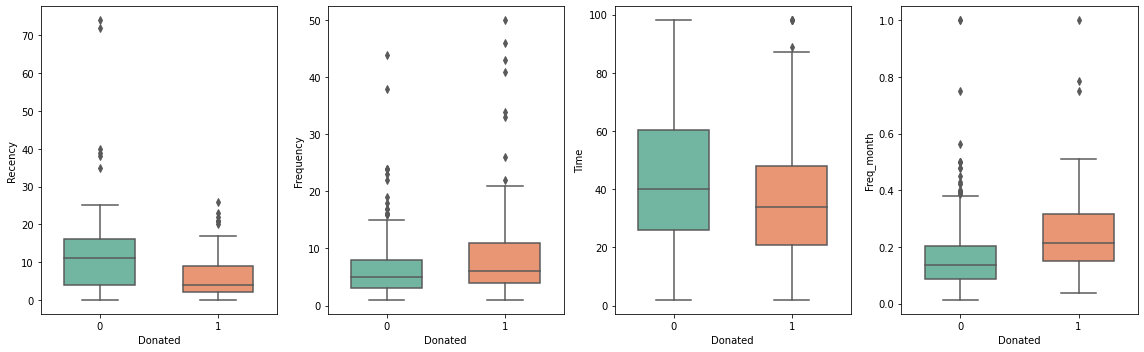

In [16]:
fig, axes= plt.subplots(1,4, figsize=(16,5))

for i, col in enumerate(df.drop('Donated', axis=1)):
    sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
plt.tight_layout()

In [22]:
X= df.drop('Donated', axis=1)
y=df['Donated']

In [23]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, stratify=y, random_state=107)

In [25]:
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [26]:
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

### 1) Confusion matrix
- A confusion matrixthe represents the number of correct and incorrect predictions broken down by each class.

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, knn.predict(X_test))

array([[85, 12],
       [26, 11]])

In [28]:
from imblearn.combine import SMOTETomek

In [29]:
smt = SMOTETomek(sampling_strategy='auto', random_state=105)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [30]:
svc=SVC(probability=True)

svc.fit(X_train_smt, y_train_smt)

SVC(probability=True)

In [31]:
confusion_matrix(y_test, svc.predict(X_test))

array([[77, 20],
       [12, 25]])

In [32]:
from sklearn.metrics import accuracy_score

print ('Accuracy (dataset desbalanceado): {:2.2%}'.format(accuracy_score(y_test, knn.predict(X_test))))
print ('Accuracy (dataset balanceado): {:2.2%}'.format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy (dataset desbalanceado): 71.64%
Accuracy (dataset balanceado): 76.12%


In [33]:
from sklearn.metrics import recall_score

print ('Sensitividad: {:2.2%}'.format(recall_score(y_test, svc.predict(X_test))))

Sensitividad: 67.57%


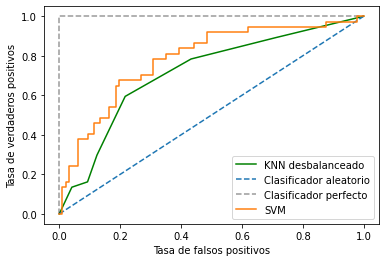

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

auc_svc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])
fpr_svc, tpr_svc, _ = roc_curve(y_test,  svc.predict_proba(X_test)[:,1])

random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
fpr_rn, tpr_rn, _ = roc_curve(y_test, random_probs)

auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
fpr_knn, tpr_knn, _ = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

auc_perfect = roc_auc_score(y_test, y_test)
fpr_pr, tpr_pr, _ = roc_curve(y_test, y_test)

plt.plot(fpr_knn,tpr_knn,label="KNN desbalanceado", color='green')
plt.plot(fpr_rn, tpr_rn, linestyle='--', label='Clasificador aleatorio')
plt.plot(fpr_pr, tpr_pr, linestyle='--',color='black', alpha=0.4, label='Clasificador perfecto')
plt.plot(fpr_svc,tpr_svc,label="SVM")
plt.ylabel('Tasa de verdaderos positivos')
plt.xlabel('Tasa de falsos positivos')
plt.legend(loc="lower right")
plt.show()